## Astro 304 "Galaxies"

### Luminosity function of galaxies in SDSS

You can turn this notebook into a slide show using nbconvert package:

jupyter-nbconvert --to slides ex05_sdss_luminosity_function.ipynb --post serve

In [1]:
# preliminaries to set up work space
import numpy as np

# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

In [2]:
from code.read_sdss_fits import read_sdss_fits
from code.setup.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does 
# not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster ~16 Mpc away from the Milky Way
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 0.4

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 12; m_max = 17.77

# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
cmr = data['cmodelMag_r'] - data['extinction_r']
cmg = data['cmodelMag_g'] - data['extinction_g']
gr = cmg - cmr

# apply redshift, magnitude, and color cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-2.5) & (gr<2.5)]

print("selected %d galaxies"%np.shape(data['z']))


selected 649968 galaxies


In [3]:
# now compute luminosity and angular diameter distances for galaxies in the sample
from code.cosmology import d_l
# define suitable cosmological parameters
# mean matter and vacuum energy densities in units of the critical density 
h = 0.7 # H0/100
Om0 = 0.3; OmL = 0.7
d_H = 2997.92 # c/(100 km/s/Mpc) 

z = data['z']

d_L = d_l(z, Om0, OmL, ninter=20)
d_A = d_L / (1.+z)**2

# dimensionless distance -> Mpc 
d_L *= d_H / h; d_A *= d_H /h 

# Petrosian and cmodel magnitudes in the r band, extinction corrected. 
mpetro = data['petroMag_r'] - data['extinction_r']
mcmodel = data['cmodelMag_r'] - data['extinction_r']

# cmodel and Petrosian absolute magnitudes in the r-band
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5)
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5)

# now account for evolution and apply K-correction

# g-r color for computing K-correction using cmodel magnitudes
gr = data['cmodelMag_g'] - data['extinction_g'] - data['cmodelMag_r'] + data['extinction_r']

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not designed for z>0.6, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

Mcmodel = Mcmodel - kcorr + 1.3*z
Mpetro  = Mpetro - kcorr + 1.3*z

# finally, compute log10 of r-band luminosity in Lsun,r from the cmodel and Petrosian absolute mmagnitudes
Lcmodel =  0.4*(4.67-Mcmodel)
Lpetro =  0.4*(4.67-Mpetro)

### Luminosity function of galaxies

If not for the Malmquist bias, measuring the luminosity function would be equivalent to just histogramming galaxy luminosities and normalizing by the volume of the sample. However, if we just do that to compute the $r$-band luminosity function of SDSS galaxies, we will get the following

In [4]:
# Now let's compute luminosity function, which is just a histogram
# Note that we bin log10(L), so what we will get is dn(L)/dlog10(L)
nbins = 80
phi_Lbiased, Lbins = np.histogram(Lcmodel, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# normalize the histogram by the survey volume
d_Lmax = d_l(z_max, Om0, OmL, ninter=20)
d_Lmin = d_l(z_min, Om0, OmL, ninter=20)

# dimensionless distance -> /h Mpc 
d_Lmax *= d_H / h; d_Lmin *= d_H / h
# luminosity distance -> comoving distance needed for volum
d_Mmax = d_Lmax / (1.+z_max); d_Mmin = d_Lmin / (1.+z_min)

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

solid_anglem = 4.*np.pi *0.195

# comoving survey volume assuming flat cosmology
vsurvey = ccm * solid_anglem / 3. * (np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# finally normalize by volume and convert to dn/dlog10 L in h^3 Mpc^-3 and L to h^2 Lsun
phi_Lbiased = phi_Lbiased / vsurvey / dLbins / h**3
Lbinc = np.log10(10.**Lbinc/h**2)


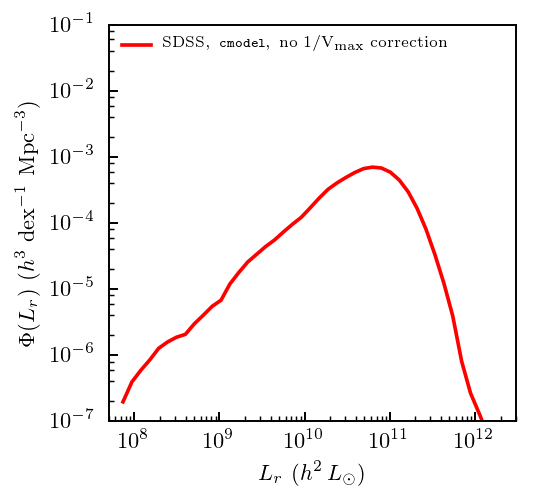

In [5]:
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lbiased, c='r', label=r'$\mathrm{SDSS,\ {\tt cmodel},\ \mathrm{no}\ 1/V_{\rm max}\ \rm correction }$')

plt.legend(loc='upper left', fontsize=6, frameon=False)

plt.show()

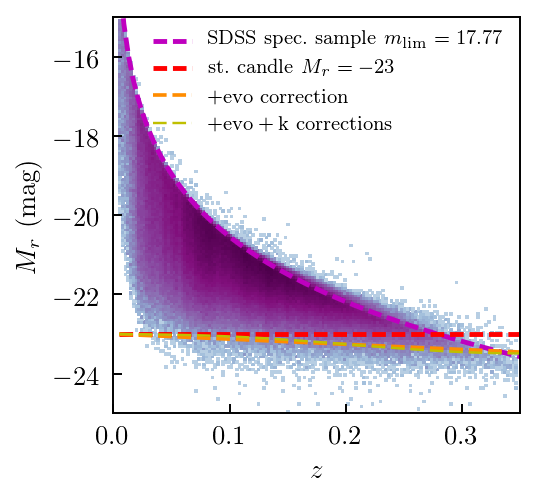

In [6]:
from code.plot_utils import plot_Mz

zlim = [0.0, 0.35]; Mrlim = [-25,-15.]
plot_Mz(z, Mcmodel,  xlim=zlim, ylim=Mrlim, nxbins=151, nybins=151, 
        xlabel=r'$z$', ylabel=r'$M_{r}\ \mathrm{(mag)}$', 
        Om0 = 0.3, OmL = 0.7, h = 0.7, 
        savefig=None)

### Luminosity function of galaxies: unbiased shape

The methods that are used in practice include a method for accounting for this bias, and also often methods to mitigate sample variance, distance errors, etc. The simplest method accounting for just the Malmquist bias is the $1/V_{\rm max}$ method - i.e., constructing a histogram of galaxy luminosities with $1/V_{\rm max}$ weights. 

In [7]:
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+z)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+z)

vmaxi = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
cc = 0.93

# solid angle of the main SDSS sample
solid_angle = 9274.*(np.pi/180)**2
# 1/Vmax
vmaxi = vmaxi / (solid_angle*cc)

# again, LF is a histogram, but in this case it's a weighted histogram
phi_Lcmodel, Lbins = np.histogram(Lcmodel, weights=vmaxi, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# convert to dn/dlog10 L in h^3 Mpc^-3 and L to h^2 Lsun
# no need to normalize by volume here, because we weigh each galaxy with inverse volume
phi_Lcmodel = phi_Lcmodel / dLbins / h**3
Lbinc = np.log10(10.**Lbinc/h**2)


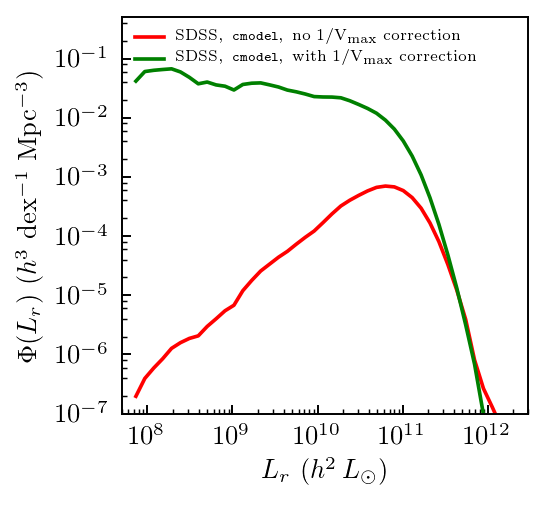

In [8]:
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.5)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lbiased, c='r', label=r'$\mathrm{SDSS,\ {\tt cmodel},\ \mathrm{no}\ 1/V_{\rm max}\ \rm correction }$')
plt.plot(10.**Lbinc, phi_Lcmodel, c='g', label=r'$\mathrm{SDSS,\ {\tt cmodel},\ \mathrm{with}\ 1/V_{\rm max}\ \rm correction }$')

plt.legend(loc='upper left', fontsize=6, frameon=False)

plt.show()

### Schechter form of the luminosity function

Number density of galaxies of luminosity in range $L\in[L,L+dL]$ in space as a function of their luminosity, $n(L)$, is called the <b>luminosity function</b>. 

It is often parametrized with the <a href="http://adsabs.harvard.edu/abs/1976ApJ...203..297S">Schechter (1976)</a> functional form: 
$$
\phi(L)\equiv\frac{dn(L)}{dL}=\frac{\phi_\star}{L_\star} \left(\frac{L}{L_\star}\right)^{\alpha}\exp(-L/L_\star),
$$
where $\alpha$ is the logarithmic slope of the function at low $L$ and $L_\star$ is the characteristic luminosity at which the function transitions from power law to the exponential cutoff. We saw this cutoff in the $M_r-z$ distribution of galaxies. 

Here is the luminosity function from the Schechter (1976) paper, one of the papers for which Paul Schechter became famous. The fame is reflected in the accompanying cartoon, which humors the statements that parameters of the galaxy luminosity function are independent of environment (i.e., LF is "universal"). The cartoon also emphasizes the main features of the function: the faint-end slope $\alpha$, the characteristic luminosity $L_\star$ (or absolute magnitude, $M_\star$), and potential uncertainties related to the brightest galaxies in clusters (BCGs).

<img width=300 align=left src="http://astro.uchicago.edu/~andrey/classes/a304/fig/schechter76_lf.png"></img>
<img width=300 align=left src="http://astro.uchicago.edu/~andrey/classes/a304/fig/schechter_lf_binggeli_cartoon.jpg"></img>

In [9]:
# fit Schechter form to the 1/Vmax corrected LF estimated above
from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lcmodel>1.e-7) & (Lbinc>9.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lcmodel[fitsel]; ephi_fit = np.ones_like(phi_Lcmodel[fitsel])

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print("best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2]))

best fit Schechter parameters: phi_*=1.10e-02 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=10.78, alpha=-0.10


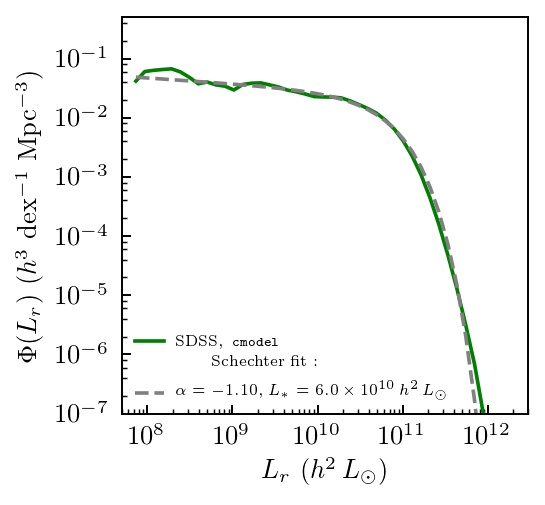

In [10]:
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.5)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lcmodel, c='g', label=r'$\mathrm{SDSS,\ {\tt cmodel}}$')

# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', 
         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_*=%.1f\times 10^{%d}\,h^2\,L_\odot$'%((popt[2]-1),10.**Lsnum,Lsexp))

plt.legend(loc='lower left', fontsize=6, frameon=False)
plt.savefig('fig/lf_sdss.png')
plt.show()

We can see in the LF plot that Schechter function cuts off a bit too fast at brighest luminosities. Thus, to fix this, sometimes a modified form with an extra parameter is used: 

$$\phi(L)\equiv\frac{dn(L)}{dL}=\frac{\phi_*}{L}\frac{\beta}{\Gamma(\alpha/\beta)} \left(\frac{L}{L_*}\right)^{\alpha}\exp(-[L/L_*]^\beta)$$,

where $\Gamma(x)$ is the gamma function and $\beta$ is additional parameter that provides more flexibility at high luminosities. Bernardi et al. (2013) and some others use a sum of two Schechter functions two characterize total luminosity function. Such double-Schechter fit is shown as the dashed green line in the plot above. 

### Difficulty of measuring luminosity function at small luminosities: surface brightness limit

Low luminosity galaxies tend to be low surface brightness and at the lowest luminosities probed by SDSS a fraction of galaxies is missed due to surface brightness limit of the main SDSS sample. 

In [11]:
# surface brightness within r50
size = data['petroR50_r']; 
# compute surface brightnesses
sb50 = mcmodel - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) 

mulim = 22.5
lsb = (sb50 > mulim)

# LF of low surface brightness galaxies
phi_Lcmodel_lsb, Lbins = np.histogram(Lcmodel[lsb], weights=vmaxi[lsb], bins=nbins)
Lbinc_lsb = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# convert to dn/dlog10 L in h^3 Mpc^-3 and L to h^2 Lsun
# no need to normalize by volume here, because we weigh each galaxy with inverse volume
phi_Lcmodel_lsb = phi_Lcmodel_lsb / dLbins / h**3
Lbinc_lsb = np.log10(10.**Lbinc_lsb/h**2)


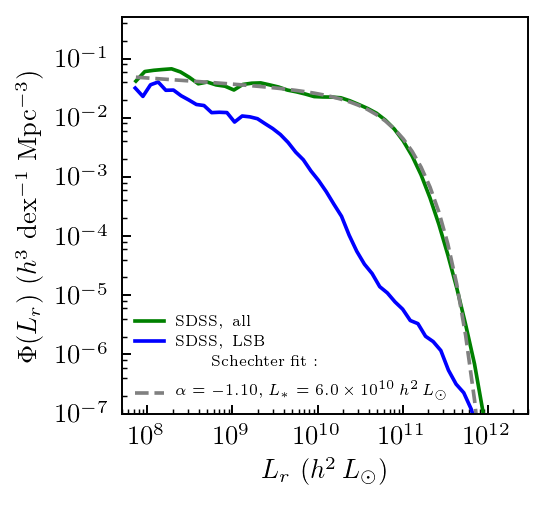

In [12]:
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.5)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lcmodel, c='g', label=r'$\mathrm{SDSS,\ {\rm all}$')
plt.plot(10.**Lbinc_lsb, phi_Lcmodel_lsb, c='b', label=r'$\mathrm{SDSS,\ LSB}$')

# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', 
         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_*=%.1f\times 10^{%d}\,h^2\,L_\odot$'%((popt[2]-1),10.**Lsnum,Lsexp))

plt.legend(loc='lower left', fontsize=6, frameon=False)

plt.show()

### What are these LSB galaxies?

C:\Users\h2_sf\Canopy2\User\lib\site-packages\matplotlib\axes\_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\h2_sf\Canopy2\User\lib\site-packages\matplotlib\axes\_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


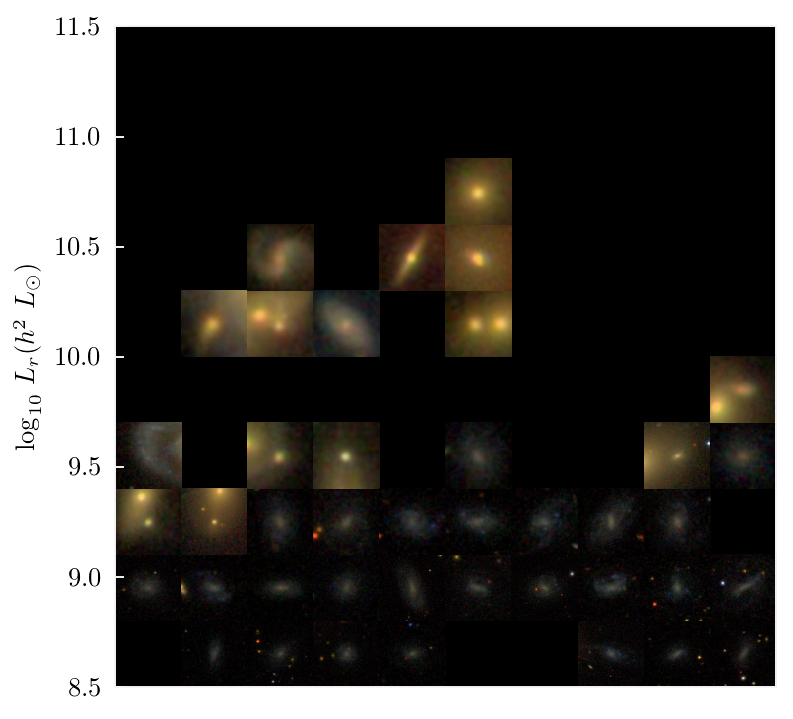

In [13]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

Dmax = 500. 

lsb = ((sb50 > 23) & (d_L < Dmax))
lsbdata = data[lsb]; 
objs = lsbdata['objID']; ras = lsbdata['ra']; decs = lsbdata['dec']
Llsb = Lcmodel[lsb]

ylabel = r'$\log_{10}\,L_r (h^{2}\ L_\odot)$'
nrows = 10; ncols = 10; rnd_seed = 4647
xlims = [0.,ncols]; ylims = [8.5,11.5]

xdummy = np.random.uniform(ncols,size=np.size(Llsb)) - 0.5

plot_sdss_collage_with_2d_dist(objs, ras, decs, 
                               xs=xdummy, ys=Llsb, 
                               xlims = xlims, ylims=ylims, xlab=' ', ylab=ylabel, 
                               show_axis=True, show_xaxis = False, show_yaxis=True, 
                               nrows=nrows, ncols=ncols, npix = 200, 
                               rnd_seed=rnd_seed, facecolor='black', kpc_per_npix = 20, dA = d_A[lsb]) #outfile='fig/lsb_collage.png')


### Difficulty of measuring luminosity function at small luminosities: large-scale structure and peculiar velocities

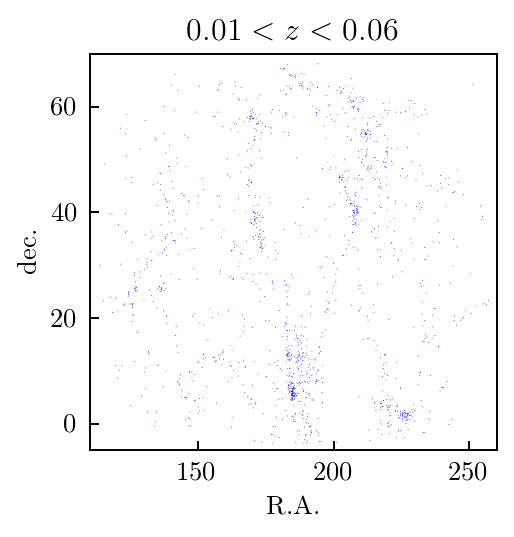

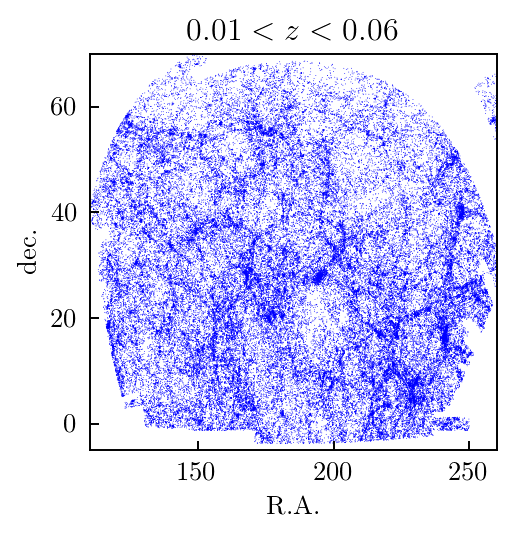

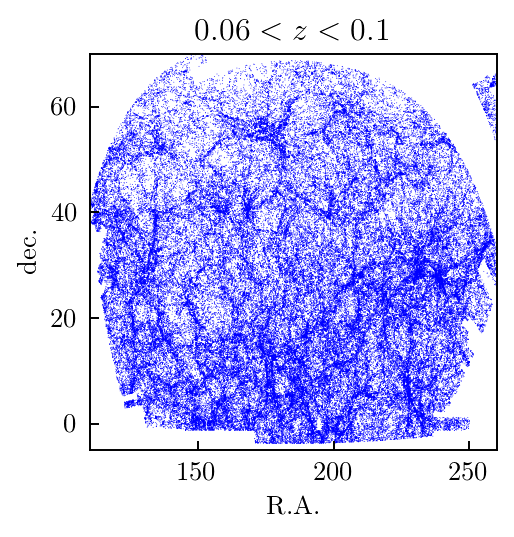

In [14]:
"""
plot distribution of SDSS galaxies on the sky

"""
# RA and DEC cuts

xlabel = r'$\mathrm{R.A.}$'; ylabel = r'$\mathrm{dec.}$'
xlim = [110.,260.]; ylim =[-5.,70]

# Plot the results

isel = ((z < 0.01) & 
        (data['dec'] > -10) & (data['dec'] < 75) & 
        (data['ra'] > 100) & (data['ra'] < 270))
datap = data[isel]

fig = plt.figure(figsize=(3, 3))
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(r'$\mathrm{R.A.}$')
plt.ylabel(r'$\mathrm{dec.}$')
plt.scatter(datap['ra'],datap['dec'], marker='.', edgecolor='none', color='blue', s=.5, alpha=1.)
plt.title(r'$0.01<z<0.06$')
plt.savefig('fig/sky_lss_z006.png')
plt.show()


isel = ((z > 0.01) & (z < 0.06) & 
        (data['dec'] > -10) & (data['dec'] < 75) & 
        (data['ra'] > 100) & (data['ra'] < 270))
datap = data[isel]

fig = plt.figure(figsize=(3, 3))
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(r'$\mathrm{R.A.}$')
plt.ylabel(r'$\mathrm{dec.}$')
plt.scatter(datap['ra'],datap['dec'], marker='.', edgecolor='none', color='blue', s=.5, alpha=1.)
plt.title(r'$0.01<z<0.06$')
plt.savefig('fig/sky_lss_z006.png')
plt.show()

isel = ((z > 0.06) & (z < 0.1) & 
        (data['dec'] > -10) & (data['dec'] < 75) & 
        (data['ra'] > 100) & (data['ra'] < 270))
datap = data[isel]

fig = plt.figure(figsize=(3, 3))
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(r'$\mathrm{R.A.}$')
plt.ylabel(r'$\mathrm{dec.}$')
plt.scatter(datap['ra'],datap['dec'], marker='.', edgecolor='none', color='blue', s=.5, alpha=1.)

plt.title(r'$0.06<z<0.1$')
plt.savefig('fig/sky_lss_z010.png')
plt.show()


###  Large-scale structure in galaxy distribution: some history

The fact that nebulae are distributed non-uniformly on the sky was known in the 19th century after sufficiently large catalogs of nebulae have been constructed by Herschel and others. 

Here is a map of nebulae on the sky in the <a href="http://adsabs.harvard.edu/abs/1869MNRAS..29..337P">paper</a> by British astronomer <a href="https://en.wikipedia.org/wiki/Richard_A._Proctor">Richard A. Proctor</a> published in 1869. You can see clusters and extended, filamentary structures in the distribution that are the main characteristic of the distribution of galaxies, as we know it today. The fact that distribution of nebulae was non-uniform and was different from the stellar band of the Milky Way was one of the earliest indications that these nebulae were outside of our Galaxy. 

<img width=800 align=left src="http://astro.uchicago.edu/~andrey/classes/a304/fig/proctor1869_lss.png"></img>

### Distribution of galaxies in the vicinity of the Milky Way

Even within a few Megaparsecs of the Milky Way, the distribution of galaxies is highly non-uniform: galaxies within 10 Mpc of the MW are distributed in a sheet like structure. You can view the distribution of galaxies within $\pm 10$ Mpc distance from the Milky Way by running code <tt>code/lsc_visualize.py</tt>

It needs <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/mcconnachie12.fits">this</a> and <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/karachentsev13_BMag.txt">this</a> file from our data directory, so please place them into your local data/ subdirectory. 

You can also see some visualizations and movies of the local large-scale structure at <a href="http://www.ifa.hawaii.edu/~tully/outreach/">Brent Tully's website.</a> 

### Distribution of galaxies in "3D": Coma cluster and nearby superclusters

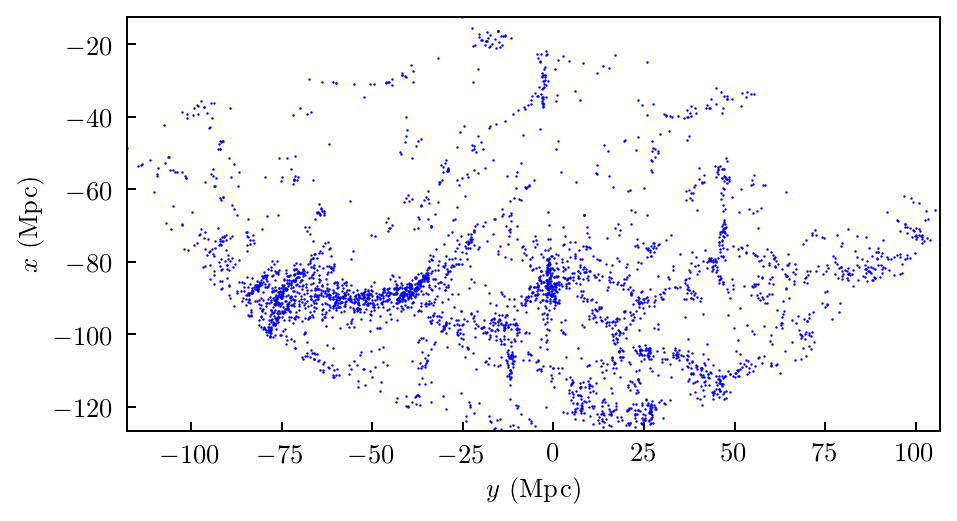

In [15]:
isel = ((data['dec'] > -7) & (data['dec'] < 7) & 
        (data['ra'] > 80) & (data['ra'] < 280) &
        (data['z'] > 0.0) & (data['z'] < 0.03) & (Mcmodel<-17.))

gwdata = data[isel]; 
# comoving los distance
d_C = d_L[isel]/(1. + gwdata['z'])

X = np.vstack([d_C * np.cos(gwdata['ra'] * np.pi / 180.),
               d_C * np.sin(gwdata['ra'] * np.pi / 180.)]).T

fig = plt.figure(figsize=(6, 6))

ax = plt.subplot(111, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='b')

ax.set_xlim(np.min(X[:,1]), np.max(X[:,1]))
ax.set_ylim(np.min(X[:,0]), np.max(X[:,0]))

ax.set_xlabel(r'$y\ (\rm Mpc)$')
ax.set_ylabel(r'$x\ (\rm Mpc)$')
plt.savefig('fig/local_lss_coma.png')
plt.show()



### SDSS Great Wall supercluster

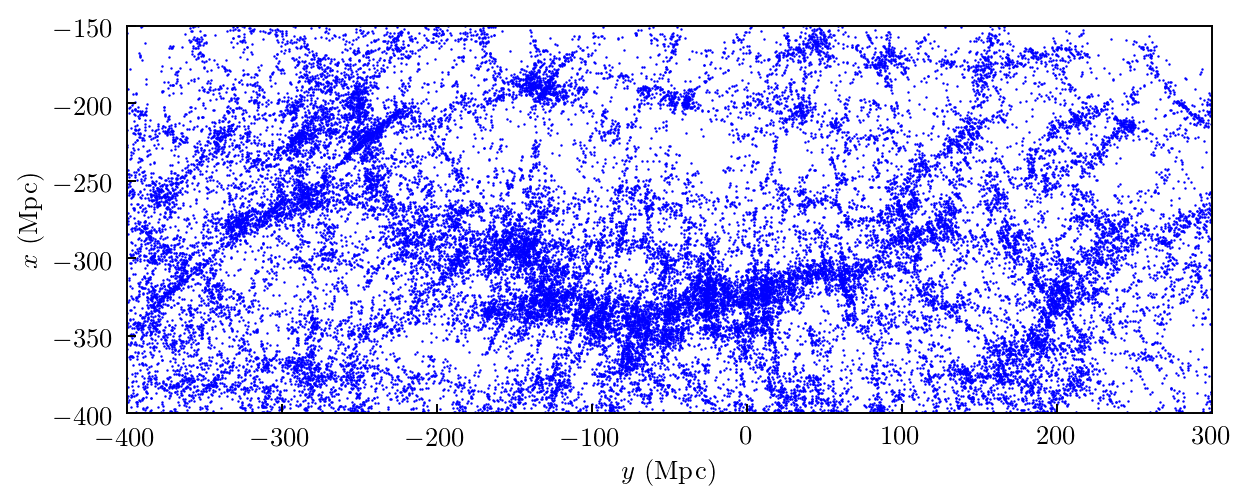

In [16]:
isel = ((data['dec'] > -7) & (data['dec'] < 7) & 
        (data['ra'] > 80) & (data['ra'] < 280) & 
        (data['z'] > 0.01) & (data['z'] < 0.14) &
        (Mcmodel<-20.))

gwdata = data[isel]; 
# comoving los distance
d_C = d_L[isel]/(1. + gwdata['z'])

X = np.vstack([d_C * np.cos(gwdata['ra'] * np.pi / 180.),
               d_C * np.sin(gwdata['ra'] * np.pi / 180.)]).T

fig = plt.figure(figsize=(8, 6))

ax = plt.subplot(111, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='b')

ax.set_xlim(-400, 300)
ax.set_ylim(-400, -150)

ax.set_xlabel(r'$y\ (\rm Mpc)$')
ax.set_ylabel(r'$x\ (\rm Mpc)$')
plt.show()



### Peculiar velocities

For nearby galaxies (low luminosity) or for galaxies near very large structures distances become inaccurate due to *peculiar motions*.

If physical distance between two galaxies is $r$, comoving distance between is $x=r/a$ (where a(t) is normalized to 1 at $z=0$). 
Thus, relative velocity between these two galaxies is 

$$
\dot{r}=\dot{a}x + a\dot{x}.
$$

If galaxies were simply coasting with the expansion of the universe, we would have $\dot{x}=0$ by definition and pure Hubble law:

$$\dot{r}=\dot{a}x=\frac{\dot{a}}{a}\, r=H(a)r;\ \ \ \ H(a)=\frac{\dot{a}}{a}$$

However, because distribution of matter is not completely homogeneous, galaxies feel forces of gravity due to local inhomogeneities that perturb their motion away from the pure Hubble flow. Thus, $\dot{x}\ne 0$ and

$$
\dot{r}=cz=H(a)r + av_{\rm pec},\ \ \ \mathrm{where}\ v_{\rm pec}=\mathrm{peculiar\  velocity}.
$$
We measure distances from $z$ as $d=cz/H$. Thus, what we are measuring is

$$ d = r + \frac{a}{H}v_{\rm pec} = r + \frac{1}{H}\frac{v_{\rm pec}}{1+z}.$$

So the positions of galaxies in the Great Wall region (or any time we use redshift as proxy for distance) will be distorted by $v_{\rm pec}/(1+z)/H$, which is manifested in the "streaks" in galaxy distribution pointing towards us. Most prominent ones are strangely called the *"fingers-of-God"* (because they all are extended structures "pointing" at us) and are due to galaxy motions inside massive galaxy clusters. 

### Difficulties in measuring luminosity function: treating background properly and measuring galaxy flux reliably 

### The UPenn version of the SDSS catalog

In what follows, as well as for homework 2 assignment, we will use a different version of the SDSS spectroscopic catalog: the <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalogs</a> with their model photometry fits to the SDSS DR7 main galaxy sample (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). The catalog files are available in the data/ directory shared with you previously, which can be found  <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/">here</a> in the subdirectory <tt>data/Meert2015_v2/</tt>. The file <tt>data_tables</tt> in this subdirectory contains description of the information contained in the catalog (some of it is duplicates from the SDSS catalogs, but much of it is new). Unlike, previous dataset the UPenn catalog comes as a collection of FITS files. I provide a routine for reading them and you can find example code below that shows how the catalog is read and how some cuts are applied to derive a clean sample of galaxies. 

In [17]:
#import routine that reads SDSS catalog with photometry from Meert et al
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  
# 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) 
        & (sb50 > 0.) & (sb50 <= 25.) & (grm>-0.5) & (grm<2.2))

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print("selected %d galaxies after all cuts"%np.size(zm))

# luminosity distance in Mpc
from code.cosmology import d_l

Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

d_Lm = d_l(zm, Om0, OmL, ninter=20)

# dimensionless distance -> Mpc 
d_Lm *= d_H / h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# 0.195 is the fraction of total sky solid angle that is covered by the UPenn photometric catalog, 
# as reported by them
solid_anglem = 4.*np.pi/3*0.195
# 1/Vmax
vmaxim = vmaxim / (solid_anglem*ccm)

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; 
pSab = morph['probaSab']; pScd = morph['probaScd']; 


670722 galaxies in Meert et al. sample initially
selected 245197 galaxies after all cuts


In [18]:
import numpy as np

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))

grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']


# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

mulim = 24.5

ilim = ((mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & 
        (sb50 > 0.) & (sb50 <= mulim) & (grm>-0.5) & (grm<2.2))

ssdata = sdata[ilim]; smdata = mdata[ilim]; sphot_r = phot_r[ilim] 
smnpdata = mnpdata[ilim]; sgrm = grm[ilim]
zm = ssdata['z']; mpetrom = sphot_r['petroMag']; mmeert = smdata['m_tot']
ssb50 = sb50[ilim]; extm = smnpdata['extinction']; kcorr = smnpdata['kcorr']

print("selected %d galaxies after all cuts..."%np.size(zm))

# in the Meert catalog Vmax is pre-computed and provided for each galaxy 
vmaxm = mnpdata['Vmax']

# compute luminosity distance
from code.cosmology import d_l

Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

d_Lm = d_l(zm, Om0, OmL)

# dimensionless distance -> Mpc 
d_Lm *= d_H / h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;
Mmodel = sphot_r['ModelMag'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, 
# so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): 
# Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# 4.67 is the r-band abs. magntidue of the Sun
# compute log10(L) for differently defined abs. magnitudes
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
Lmodel = 0.4*(4.67-(Mmodel))
# limiting redshift for surface brightness of 23 mag/arcsec^2
zsb = (1.+zm)*np.power(10.,0.1*(mulim-ssb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = d_l(zsb, Om0, OmL) * d_H / h / (1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

# 0.195 is the fraction of total sky solid angle that is covered by the UPenn photometric catalog, 
# as reported by them
solid_anglem = 4.*np.pi * 0.195
# 1/Vmax
vmaxim = vmaxim / (solid_anglem*ccm)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute LF for the luminosities using UPenn photometry derived from Sersic profile fits to galaxy profiles
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)
# compute LF using the Petrosian magnitudes from the original SDSS pipeline
phi_Lpetro, ephi_Lpetro = compute_lf_bootstrap(Lpetrom, vmaxim, Lbins, nbootstrap)
# compute LF using the cmodel magnitudes from the original SDSS pipeline
phi_Lmodel, ephi_Lmodel = compute_lf_bootstrap(Lmodel, vmaxim, Lbins, nbootstrap)

#normalize and scale LF properly
phi_Lbsmeert = phi_Lbsmeert  / dLbins / h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

phi_Lpetro = phi_Lpetro  / dLbins / h**3
ephi_Lpetro = ephi_Lpetro  / dLbins / h**3
ephi_Lpetro = np.nan_to_num(ephi_Lpetro)

phi_Lmodel = phi_Lmodel  / dLbins / h**3
ephi_Lmodel = ephi_Lmodel  / dLbins / h**3
ephi_Lmodel = np.nan_to_num(ephi_Lmodel)
# scale bin centers
Lbinc = np.log10(10.**Lbinc/h**2)

# Fit Schechter functional form to the measured luminosity function
from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lbsmeert>1.e-7) & (Lbinc>8.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lbsmeert[fitsel]; ephi_fit = ephi_Lbsmeert[fitsel]

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print("best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2]))

selected 245194 galaxies after all cuts...
best fit Schechter parameters: phi_*=9.53e-03 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=10.88, alpha=-0.19


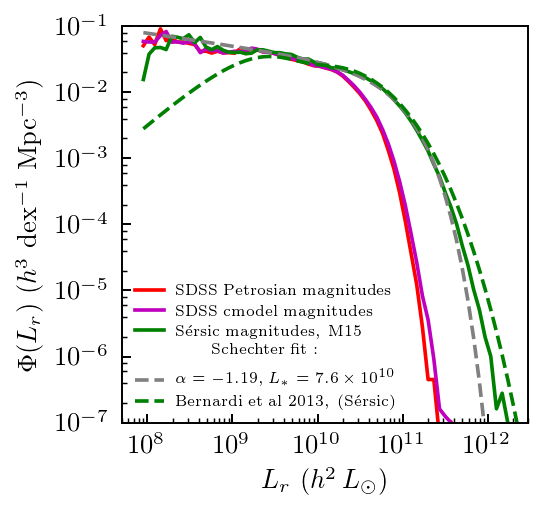

C:\Users\h2_sf\Canopy2\User\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: divide by zero encountered in log10


In [20]:
#
# plot  different measured LFs
#
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lpetro, c='r', label=r'$\mathrm{SDSS\ Petrosian\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lmodel, c='m', label=r'$\mathrm{SDSS\ cmodel\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')

#plt.errorbar(10.**Lbinc, phi_Lbsmeert, yerr=ephi_Lbsmeert, c='g')
# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', 
         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_*=%.1f\times 10^{%d}$'%((popt[2]-1),10.**Lsnum,Lsexp))

ms = 10.**Lbinc

# Sersic photometry LF parameters
# 0.73/0.7 factors below is to account for the difference in the assumed Hubble constant in Bernardi et al. 2013 
# and h=0.7 adopted here
import math
mstarb = 0.0187e9/h**2; phisb = 1.343e-2/h**3; alphab = 1.678; betab = 0.3
mstarg = 0.8722e9/h**2; phisg = 0.843e-2/h**3;  gammag = 1.058
gammanorm = math.gamma(alphab/betab)

musb = ms/mstarb; musg = ms/mstarg
phiLB13_ser = np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
         phisg*musg**(gammag)*np.exp(-musg))


plt.plot(10.**Lbinc, phiLB13_ser, '--', c='g', label=r'$\mathrm{Bernardi\ et\ al\ 2013,\ (S\acute{e}rsic)}$')

plt.legend(loc='lower left', fontsize=6, frameon=False)

#plt.grid(ls='dotted')
plt.savefig('fig/lf_sdss_meert.png')
plt.show()

# save Meert LF an its Schechter fit
dwr = np.array([Lbinc, np.log10(phi_Lbsmeert), np.log10(lf_schechter(Lbinc, popt[0], popt[1], popt[2]))]).T
np.savetxt('data/lf_sdss_meert.dat', dwr, fmt=['%1.4e', '%1.4e', '%1.4e'])


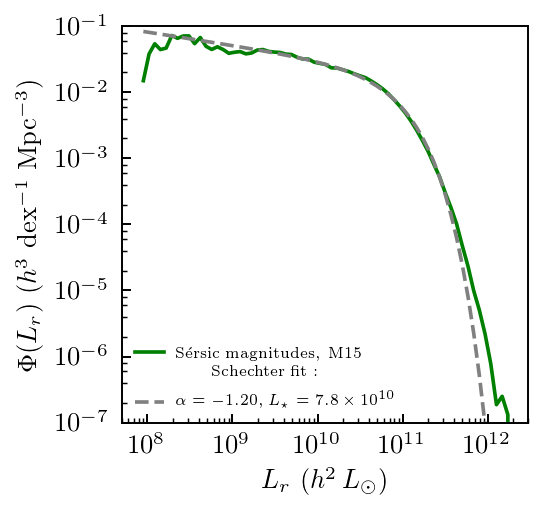

In [16]:
#
# plot  different measured LFs
#
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^2\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 3e12); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')

#plt.errorbar(10.**Lbinc, phi_Lbsmeert, yerr=ephi_Lbsmeert, c='g')
# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', 
         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_\star=%.1f\times 10^{%d}$'%((popt[2]-1),10.**Lsnum,Lsexp))

ms = 10.**Lbinc

plt.legend(loc='lower left', fontsize=6, frameon=False)

#plt.grid(ls='dotted')
plt.savefig('fig/lf_sdss_meert.png', bbox_inches='tight')
plt.show()